# Field Biodiversity Data Process
This notebook is dedicated to create a shapefile which contains geospatial information of forest species collected by field survey.   
The workflow is as following: 
1. Transliterate the field handwritten data into digital data saved in excel. 
2. Create geodataframe and save it as a shapefile, meanwhile remove redundant data. 
3. Calculate the alpha and beta diversity. (?point?resample). 
4. Visualize the result, either in QGIS or Python (plot or WebGIS). 

In [52]:
import pandas as pd
import geopandas as gpd
from osgeo import gdal
import rasterio as rio

In [53]:
# Set some directories. Here we use absolute directories. 
cwd = 'c:\\Users\\m1865\\Desktop\\Ticino'
cwd_Field = cwd + '\\FieldData'
a = gpd.read_file(cwd_Field + '\\fieldplots.shp')


In [54]:
df_FieldSpezie = pd.read_excel(cwd_Field + '\\Sintesi_siti_ParcoTicino_con_specie.xlsx')
df_FieldSpezie.head()

,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Field_campaing,Leaf_sampling,Lat,Long,X_UTM (est),Y_UTM (nord),...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,FOR01,FOR44,diga,2022-06-14,1,y,45°34.0787',8°42.7080',477510.968,5046089.097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
1,FOR02,FOR45,diga,2022-06-14,1,y,45°34.2126',8°42.7501',477566.636,5046336.872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,FOR03,FOR46,diga,2022-06-14,1,y,45°34.1851',8°42.7864',477613.662,5046285.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7
3,FOR04,FOR40,Bosco cancello,2022-06-16,1,y,45°17.4106',8°56.1672',494990.757,5015188.194,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,FOR05,FOR41,Bosco cancello,2022-06-16,1,y,45°17.4494',8°56.3050',495170.934,5015259.820,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [55]:
# FOR 32 - FOR 50 don't have any data about forest, therefore currently they need to be removed. But here we use a general method to remove those rows where there are no data of any plant. 
index_1st = df_FieldSpezie.columns.get_loc('Piano Dominante - Robinia Pseudoacacia')
index_lst = df_FieldSpezie.columns.get_loc('Piano Dominato - Copertura')
# First we need to check if all these columns in a row are NaN, and obtain a dataseries containing boolean values. 
index_List_Bool = df_FieldSpezie.iloc[:,index_1st:index_lst].isnull().all(axis=1)
# Retrieve the indices of the rows from the boolean dataseries above
index_List_Discard = index_List_Bool[index_List_Bool].index
# Drop them and check! 
df_FieldSpezie_NonEmpty = df_FieldSpezie.drop(index_List_Discard).reset_index()
df_FieldSpezie_NonEmpty

,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Field_campaing,Leaf_sampling,Lat,Long,X_UTM (est),...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,FOR01,FOR44,diga,2022-06-14,1,y,45°34.0787',8°42.7080',477510.968,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
1,1,FOR02,FOR45,diga,2022-06-14,1,y,45°34.2126',8°42.7501',477566.636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,FOR03,FOR46,diga,2022-06-14,1,y,45°34.1851',8°42.7864',477613.662,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7
3,3,FOR04,FOR40,Bosco cancello,2022-06-16,1,y,45°17.4106',8°56.1672',494990.757,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,FOR05,FOR41,Bosco cancello,2022-06-16,1,y,45°17.4494',8°56.3050',495170.934,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,77,FOR78,NaN,NaN,2022-11-11,Rilievi_new,n,45°39.4093',8°44.1476',479415.734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
59,78,FOR79,NaN,NaN,2022-11-11,Rilievi_new,n,45°39.3968',8°44.0236',479254.696,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0.4
60,79,FOR80,NaN,NaN,2022-11-11,Rilievi_new,n,45°39.8128',8°43.7756',478935.217,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
61,80,FOR81,NaN,NaN,2022-11-11,Rilievi_new,n,45°39.9103',8°43.3556',478390.540,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3


In [56]:
# Get a list of all the column names, so we can choose some of them to drop
print(df_FieldSpezie_NonEmpty.columns)
# We will drop the columns 'Field_campaing', 'Leaf_sampling', and those from 'Indice U pres/ass (normaliz per specie)' to 'Geomorfologia sotto ambiti'. 
df_FieldSpezie_Field_campaing = df_FieldSpezie_NonEmpty.columns.get_loc('Field_campaing')
df_FieldSpezie_Leaf_sampling = df_FieldSpezie_NonEmpty.columns.get_loc('Leaf_sampling') + 1
df_FieldSpezie_FirstColumn2Drop = df_FieldSpezie_NonEmpty.columns.get_loc('Indice U pres/ass (normaliz per specie)')
df_FieldSpezie_LastColumn2Drop = df_FieldSpezie_NonEmpty.columns.get_loc('Geomorfologia sotto ambiti') + 1 # Attention to the open interval on the right, hence "+ 1"
print("The index of the column 'Indice U pres/ass (normaliz per specie)' is " + str(df_FieldSpezie_FirstColumn2Drop))
print("The index of the column 'Geomorfologia sotto ambiti' is " + str(df_FieldSpezie_LastColumn2Drop))

Index(['index', 'ESU', 'Nome ESU Campagna 2', 'Sito_name', 'Sampling_date',
       'Field_campaing', 'Leaf_sampling', 'Lat', 'Long', 'X_UTM (est)',
       'Y_UTM (nord)', 'Indice U pres/ass (normaliz per specie)',
       'Indice U frequenza (normaliz per presenza)',
       '_diff%_MTCI_mean_100622vs300722 (30x30)',
       'Tipologia Forestale castrovinci', 'Syntaxon (warm)', 'Sampled_trees',
       'LAI_UP_Eff. PAI CE V6.1', 'LAI_DOWN_Eff. PAI CE V6.1', 'Note',
       'Specie campionate ', 'Nome Stazione metereologica',
       'LAT_stazione (grado decimale)', 'LONG_stazione (grado decimale)',
       'X_UTM (est)_stz.metereologica', 'Y_UTM (nord)_stz.metereologica',
       'Uso Suolo', 'DESCR_SOTT', 'Litologia', 'Litologia_unita',
       'Carta forestale', 'Geomorfologia sotto ambiti',
       'Piano Dominante - Robinia Pseudoacacia',
       'Piano Dominante - Carpinus Betulus',
       'Piano Dominante - Quercus Robur ',
       'Piano Dominante - Populus Canadensis',
       'Piano Domina

In [57]:
# Drop useless columns and make a new truncated dataframe
df_FieldSpezie_Core = df_FieldSpezie_NonEmpty.drop(df_FieldSpezie_NonEmpty.columns[list(range(df_FieldSpezie_Field_campaing,df_FieldSpezie_Leaf_sampling))+list(range(df_FieldSpezie_FirstColumn2Drop,df_FieldSpezie_LastColumn2Drop))],axis=1) # Here we use combined range index to drop the columns
df_FieldSpezie_Core
# We can also use .copy() function to create a new dataframe with the columns we select to keep.

,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),Piano Dominante - Robinia Pseudoacacia,...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,FOR01,FOR44,diga,2022-06-14,45°34.0787',8°42.7080',477510.968,5046089.097,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.8
1,1,FOR02,FOR45,diga,2022-06-14,45°34.2126',8°42.7501',477566.636,5046336.872,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,2,FOR03,FOR46,diga,2022-06-14,45°34.1851',8°42.7864',477613.662,5046285.820,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7
3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45°17.4106',8°56.1672',494990.757,5015188.194,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45°17.4494',8°56.3050',495170.934,5015259.820,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,77,FOR78,NaN,NaN,2022-11-11,45°39.4093',8°44.1476',479415.734,5055953.155,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
59,78,FOR79,NaN,NaN,2022-11-11,45°39.3968',8°44.0236',479254.696,5055930.468,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,NaN,NaN,0.4
60,79,FOR80,NaN,NaN,2022-11-11,45°39.8128',8°43.7756',478935.217,5056701.915,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5
61,80,FOR81,NaN,NaN,2022-11-11,45°39.9103',8°43.3556',478390.540,5056884.318,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.3


In [58]:
# We need to fill the NaN with value 0. 
df_FieldSpezie_Core_Dominante_1st = df_FieldSpezie_Core.columns.get_loc('Piano Dominante - Robinia Pseudoacacia')
df_FieldSpezie_Core_Dominante_lst = df_FieldSpezie_Core.columns.get_loc('Piano Dominante - Quercus Pubescens') + 1
df_FieldSpezie_Core_Dominato_1st = df_FieldSpezie_Core.columns.get_loc('Piano Dominato - Prunus Padus')
df_FieldSpezie_Core_Dominato_lst = df_FieldSpezie_Core.columns.get_loc('Piano Dominato - Crataegus Monogyna') + 1
df_FieldSpezie_Core.iloc[:,df_FieldSpezie_Core_Dominante_1st:df_FieldSpezie_Core_Dominante_lst] = df_FieldSpezie_Core.iloc[:,df_FieldSpezie_Core_Dominante_1st:df_FieldSpezie_Core_Dominante_lst].fillna(0)
df_FieldSpezie_Core.iloc[:,df_FieldSpezie_Core_Dominato_1st:df_FieldSpezie_Core_Dominato_lst] = df_FieldSpezie_Core.iloc[:,df_FieldSpezie_Core_Dominato_1st:df_FieldSpezie_Core_Dominato_lst].fillna(0)
# Check the updated dataframe
df_FieldSpezie_Core

,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),Piano Dominante - Robinia Pseudoacacia,...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,FOR01,FOR44,diga,2022-06-14,45°34.0787',8°42.7080',477510.968,5046089.097,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8
1,1,FOR02,FOR45,diga,2022-06-14,45°34.2126',8°42.7501',477566.636,5046336.872,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,FOR03,FOR46,diga,2022-06-14,45°34.1851',8°42.7864',477613.662,5046285.820,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7
3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45°17.4106',8°56.1672',494990.757,5015188.194,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45°17.4494',8°56.3050',495170.934,5015259.820,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,77,FOR78,NaN,NaN,2022-11-11,45°39.4093',8°44.1476',479415.734,5055953.155,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,78,FOR79,NaN,NaN,2022-11-11,45°39.3968',8°44.0236',479254.696,5055930.468,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.4
60,79,FOR80,NaN,NaN,2022-11-11,45°39.8128',8°43.7756',478935.217,5056701.915,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5
61,80,FOR81,NaN,NaN,2022-11-11,45°39.9103',8°43.3556',478390.540,5056884.318,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3


In [59]:
# We need to change the data type of those columns which contain the counts of each plant from float to int. 
# Not sure why .iloc here doesn't work, which always fails to convert float to int. Instead, here we use column names as index to select the columns. 
df_FieldSpezie_Core[df_FieldSpezie_Core.columns[df_FieldSpezie_Core_Dominante_1st:df_FieldSpezie_Core_Dominante_lst]] = df_FieldSpezie_Core[df_FieldSpezie_Core.columns[df_FieldSpezie_Core_Dominante_1st:df_FieldSpezie_Core_Dominante_lst]].astype('Int64')
df_FieldSpezie_Core[df_FieldSpezie_Core.columns[df_FieldSpezie_Core_Dominato_1st:df_FieldSpezie_Core_Dominato_lst]] = df_FieldSpezie_Core[df_FieldSpezie_Core.columns[df_FieldSpezie_Core_Dominato_1st:df_FieldSpezie_Core_Dominato_lst]].astype('Int64')
# Check the updated dataframe
df_FieldSpezie_Core.head()

,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),Piano Dominante - Robinia Pseudoacacia,...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,FOR01,FOR44,diga,2022-06-14,45°34.0787',8°42.7080',477510.968,5046089.097,10,...,0,0,0,0,0,0,0,0,0,0.8
1,1,FOR02,FOR45,diga,2022-06-14,45°34.2126',8°42.7501',477566.636,5046336.872,2,...,0,0,0,0,0,0,0,0,0,1.0
2,2,FOR03,FOR46,diga,2022-06-14,45°34.1851',8°42.7864',477613.662,5046285.820,3,...,0,0,0,0,0,0,0,0,0,0.7
3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45°17.4106',8°56.1672',494990.757,5015188.194,0,...,0,0,0,0,0,0,0,0,0,0.0
4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45°17.4494',8°56.3050',495170.934,5015259.820,0,...,0,0,0,0,0,0,0,0,0,0.0


In [60]:
# We still need to modify a bit the Latitude and Longitude, since they are strings and with degree symbols. 
# str.split() is dataseries method. Not sure how to perform it on these two columns (dataframe) at one time. 
df_FieldSpezie_Core['Lat'] = df_FieldSpezie_Core['Lat'].str.split(r'°|\'', regex = True, expand = True).iloc[:,0].apply(pd.to_numeric) + df_FieldSpezie_Core['Lat'].str.split(r'°|\'', regex = True, expand = True).iloc[:,1].apply(pd.to_numeric).apply(lambda row: row/60)
df_FieldSpezie_Core['Long'] = df_FieldSpezie_Core['Long'].str.split(r'°|\'', regex = True, expand = True).iloc[:,0].apply(pd.to_numeric) + df_FieldSpezie_Core['Long'].str.split(r'°|\'', regex = True, expand = True).iloc[:,1].apply(pd.to_numeric).apply(lambda row: row/60)
# Check the final dataframe! 
df_FieldSpezie_Core

,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),Piano Dominante - Robinia Pseudoacacia,...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,FOR01,FOR44,diga,2022-06-14,45.567978,8.711800,477510.968,5046089.097,10,...,0,0,0,0,0,0,0,0,0,0.8
1,1,FOR02,FOR45,diga,2022-06-14,45.570210,8.712502,477566.636,5046336.872,2,...,0,0,0,0,0,0,0,0,0,1.0
2,2,FOR03,FOR46,diga,2022-06-14,45.569752,8.713107,477613.662,5046285.820,3,...,0,0,0,0,0,0,0,0,0,0.7
3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45.290177,8.936120,494990.757,5015188.194,0,...,0,0,0,0,0,0,0,0,0,0.0
4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45.290823,8.938417,495170.934,5015259.820,0,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,77,FOR78,NaN,NaN,2022-11-11,45.656822,8.735793,479415.734,5055953.155,3,...,0,0,0,0,0,0,0,0,0,0.0
59,78,FOR79,NaN,NaN,2022-11-11,45.656613,8.733727,479254.696,5055930.468,0,...,0,0,0,0,0,0,7,0,0,0.4
60,79,FOR80,NaN,NaN,2022-11-11,45.663547,8.729593,478935.217,5056701.915,7,...,0,0,0,0,0,0,0,0,0,0.5
61,80,FOR81,NaN,NaN,2022-11-11,45.665172,8.722593,478390.540,5056884.318,2,...,0,0,0,0,0,0,0,0,0,0.3


In [61]:
# Drop the points which fall outside our RoI (Actually because there is human error in recording the coordinates)
row_drop_error = df_FieldSpezie_Core[df_FieldSpezie_Core['ESU'] == 'FOR55'].index
row_drop_error[0]
df_FieldSpezie_Final = df_FieldSpezie_Core.drop([row_drop_error[0]]).reset_index()
df_FieldSpezie_Final

,level_0,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),...,Piano Dominato - Acer Campestre,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura
0,0,0,FOR01,FOR44,diga,2022-06-14,45.567978,8.711800,477510.968,5046089.097,...,0,0,0,0,0,0,0,0,0,0.8
1,1,1,FOR02,FOR45,diga,2022-06-14,45.570210,8.712502,477566.636,5046336.872,...,0,0,0,0,0,0,0,0,0,1.0
2,2,2,FOR03,FOR46,diga,2022-06-14,45.569752,8.713107,477613.662,5046285.820,...,0,0,0,0,0,0,0,0,0,0.7
3,3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45.290177,8.936120,494990.757,5015188.194,...,0,0,0,0,0,0,0,0,0,0.0
4,4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45.290823,8.938417,495170.934,5015259.820,...,0,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,77,FOR78,NaN,NaN,2022-11-11,45.656822,8.735793,479415.734,5055953.155,...,0,0,0,0,0,0,0,0,0,0.0
58,59,78,FOR79,NaN,NaN,2022-11-11,45.656613,8.733727,479254.696,5055930.468,...,0,0,0,0,0,0,7,0,0,0.4
59,60,79,FOR80,NaN,NaN,2022-11-11,45.663547,8.729593,478935.217,5056701.915,...,0,0,0,0,0,0,0,0,0,0.5
60,61,80,FOR81,NaN,NaN,2022-11-11,45.665172,8.722593,478390.540,5056884.318,...,0,0,0,0,0,0,0,0,0,0.3


In [62]:
# Finally create our geodataframe
gdf_FieldSpezie = gpd.GeoDataFrame(
    df_FieldSpezie_Final,
    geometry = gpd.points_from_xy(df_FieldSpezie_Final['X_UTM (est)'], df_FieldSpezie_Final['Y_UTM (nord)']), 
    crs="EPSG:32632"
)
gdf_FieldSpezie

,level_0,index,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),...,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura,geometry
0,0,0,FOR01,FOR44,diga,2022-06-14,45.567978,8.711800,477510.968,5046089.097,...,0,0,0,0,0,0,0,0,0.8,POINT (477510.968 5046089.097)
1,1,1,FOR02,FOR45,diga,2022-06-14,45.570210,8.712502,477566.636,5046336.872,...,0,0,0,0,0,0,0,0,1.0,POINT (477566.636 5046336.872)
2,2,2,FOR03,FOR46,diga,2022-06-14,45.569752,8.713107,477613.662,5046285.820,...,0,0,0,0,0,0,0,0,0.7,POINT (477613.662 5046285.820)
3,3,3,FOR04,FOR40,Bosco cancello,2022-06-16,45.290177,8.936120,494990.757,5015188.194,...,0,0,0,0,0,0,0,0,0.0,POINT (494990.757 5015188.194)
4,4,4,FOR05,FOR41,Bosco cancello,2022-06-16,45.290823,8.938417,495170.934,5015259.820,...,0,0,0,0,0,0,0,0,0.0,POINT (495170.934 5015259.820)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,58,77,FOR78,NaN,NaN,2022-11-11,45.656822,8.735793,479415.734,5055953.155,...,0,0,0,0,0,0,0,0,0.0,POINT (479415.734 5055953.155)
58,59,78,FOR79,NaN,NaN,2022-11-11,45.656613,8.733727,479254.696,5055930.468,...,0,0,0,0,0,7,0,0,0.4,POINT (479254.696 5055930.468)
59,60,79,FOR80,NaN,NaN,2022-11-11,45.663547,8.729593,478935.217,5056701.915,...,0,0,0,0,0,0,0,0,0.5,POINT (478935.217 5056701.915)
60,61,80,FOR81,NaN,NaN,2022-11-11,45.665172,8.722593,478390.540,5056884.318,...,0,0,0,0,0,0,0,0,0.3,POINT (478390.540 5056884.318)


In [63]:
# Read our field shapefile
shp_Field = gpd.read_file(cwd_Field + '\\ShapefileCorretti\\confini_foreste_corretti.shp')

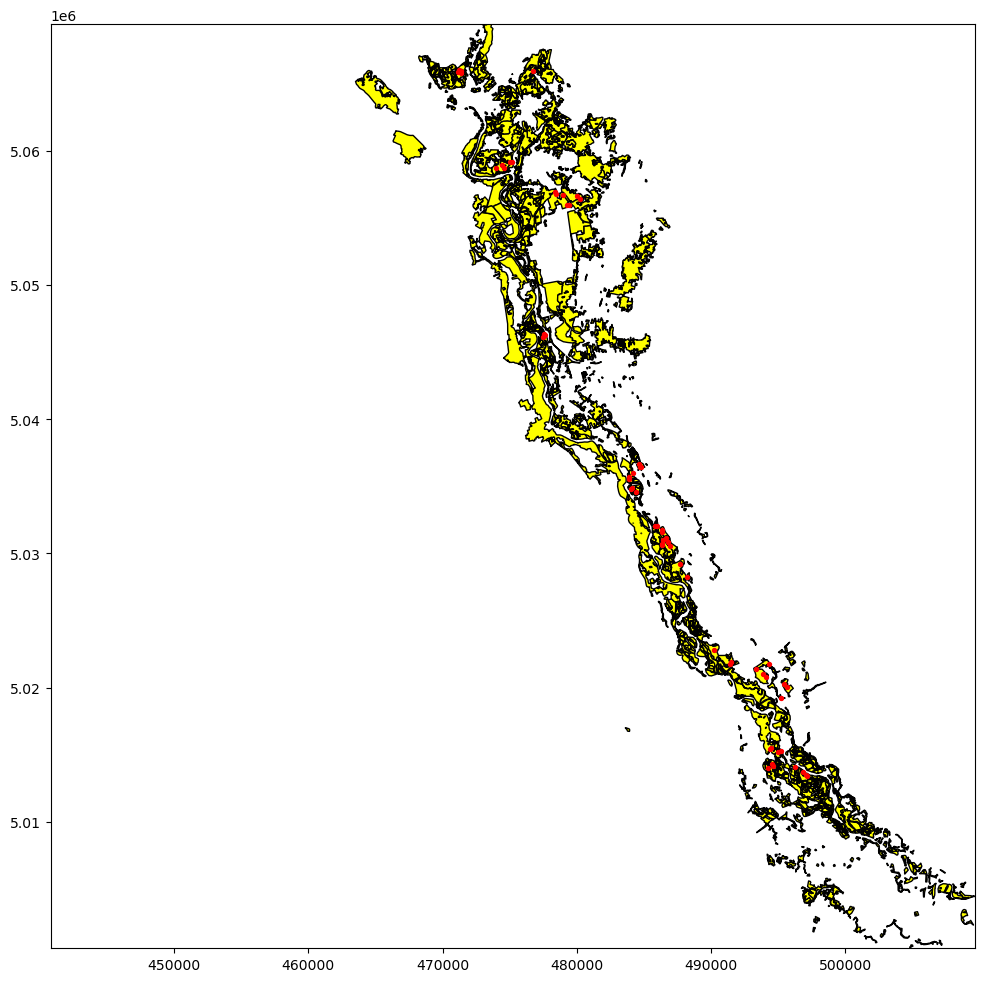

In [64]:
# Plot both our field shapefile (polygons) and our field data shapefile (points)
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,12))
shp_Field.plot(ax = ax1, color = 'yellow', edgecolor = 'black')
gdf_FieldSpezie.plot(ax = ax1, color = 'red', markersize = 8)
# Set the x and y range the same as those of our cropped raster file
ax1.set_xlim(shp_Field.total_bounds[2] - (shp_Field.total_bounds[3] - shp_Field.total_bounds[1]), shp_Field.total_bounds[2])
ax1.set_ylim(shp_Field.total_bounds[1], shp_Field.total_bounds[3])
plt.show()

In [65]:
# In order to save our shapefile, we need to modify the date column since ESRI shapefile doesn't support date-time format. 
gdf_FieldSpezie['Sampling_date'] = gdf_FieldSpezie['Sampling_date'].astype('str')
gdf_FieldSpezie['Sampling_date'].dtypes

dtype('O')

In [66]:
# Drop the auto generated "index" columns generated during the previous process
gdf_FieldSpezie_final = gdf_FieldSpezie.drop(columns=['level_0','index'])
gdf_FieldSpezie_final

,ESU,Nome ESU Campagna 2,Sito_name,Sampling_date,Lat,Long,X_UTM (est),Y_UTM (nord),Piano Dominante - Robinia Pseudoacacia,Piano Dominante - Carpinus Betulus,...,Piano Dominato - Alnus Glutinosa,Piano Dominato - Populus Tremula,Piano Dominato - Quercus Cerris,Piano Dominato - Popolus Nigra,Piano Dominato - Fraxinus Ornus,Piano Dominato - Castanea Sativa Miller,Piano Dominato - Ailanthus Altissima,Piano Dominato - Crataegus Monogyna,Piano Dominato - Copertura,geometry
0,FOR01,FOR44,diga,2022-06-14,45.567978,8.711800,477510.968,5046089.097,10,4,...,0,0,0,0,0,0,0,0,0.8,POINT (477510.968 5046089.097)
1,FOR02,FOR45,diga,2022-06-14,45.570210,8.712502,477566.636,5046336.872,2,0,...,0,0,0,0,0,0,0,0,1.0,POINT (477566.636 5046336.872)
2,FOR03,FOR46,diga,2022-06-14,45.569752,8.713107,477613.662,5046285.820,3,0,...,0,0,0,0,0,0,0,0,0.7,POINT (477613.662 5046285.820)
3,FOR04,FOR40,Bosco cancello,2022-06-16,45.290177,8.936120,494990.757,5015188.194,0,0,...,0,0,0,0,0,0,0,0,0.0,POINT (494990.757 5015188.194)
4,FOR05,FOR41,Bosco cancello,2022-06-16,45.290823,8.938417,495170.934,5015259.820,0,0,...,0,0,0,0,0,0,0,0,0.0,POINT (495170.934 5015259.820)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,FOR78,NaN,NaN,2022-11-11,45.656822,8.735793,479415.734,5055953.155,3,0,...,0,0,0,0,0,0,0,0,0.0,POINT (479415.734 5055953.155)
58,FOR79,NaN,NaN,2022-11-11,45.656613,8.733727,479254.696,5055930.468,0,0,...,0,0,0,0,0,7,0,0,0.4,POINT (479254.696 5055930.468)
59,FOR80,NaN,NaN,2022-11-11,45.663547,8.729593,478935.217,5056701.915,7,0,...,0,0,0,0,0,0,0,0,0.5,POINT (478935.217 5056701.915)
60,FOR81,NaN,NaN,2022-11-11,45.665172,8.722593,478390.540,5056884.318,2,0,...,0,0,0,0,0,0,0,0,0.3,POINT (478390.540 5056884.318)


In [69]:
# Since the names of some columns bypass the 10-character limit, we need to save their names separately into a local .txt files which will be used as an alias when we import the shapefile in other scriptes or softwares. 
# spezie_name = gdf_FieldSpezie_final.columns[8:-1]
column_name = gdf_FieldSpezie_final.columns
with open(cwd_Field + '\\fieldplots.txt', 'w') as file:
    for column in column_name:
        file.write("%s\n" % column)
    print('"fieldplots.txt" created successfully!')

"fieldplots.txt" created successfully!


In [71]:
# Save our field plots shapefile! 
gdf_FieldSpezie_final.to_file(cwd_Field + '\\fieldplots.shp')

C:\Users\m1865\AppData\Local\Temp\ipykernel_14320\2523132601.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_FieldSpezie_final.to_file(cwd_Field + '\\fieldplots.shp')
